In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from skimage.transform import resize
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray, rgba2rgb

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def show_matching_result(img1, img2, img1_pts, img2_pts):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(np.hstack((img1, img2)), cmap="gray")
    for p1, p2 in zip(img1_pts, img2_pts):
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.show()

def compute_fundamental_matrix_normalized(points1, points2):
    # validate points
    assert points1.shape[0] == points2.shape[0], "no. of points don't match"

    # compute centroid of points
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)

    # compute the scaling factor
    s1 = np.sqrt(2 / np.mean(np.sum((points1 - c1) ** 2, axis=1)))
    s2 = np.sqrt(2 / np.mean(np.sum((points2 - c2) ** 2, axis=1)))

    # compute the normalization matrix for both the points
    T1 = np.array([
        [s1, 0, -s1 * c1[0]],
        [0, s1, -s1 * c1[1]],
        [0, 0 ,1]
    ])
    T2 = np.array([
        [s2, 0, -s2 * c2[0]],
        [0, s2, -s2 * c2[1]],
        [0, 0, 1]
    ])

    # normalize the points
    points1_n = T1 @ points1.T
    points2_n = T2 @ points2.T

    # compute the normalized fundamental matrix
    F_n = compute_fundamental_matrix(points1_n.T, points2_n.T)

    # de-normalize the fundamental
    return T2.T @ F_n @ T1

def compute_fundamental_matrix(points1, points2):

    # validate points
    assert points1.shape[0] == points2.shape[0], "no. of points don't match"

    u1 = points1[:, 0]
    v1 = points1[:, 1]
    u2 = points2[:, 0]
    v2 = points2[:, 1]
    one = np.ones_like(u1)

    # construct the matrix
    # A = [u2.u1, u2.v1, u2, v2.u1, v2.v1, v2, u1, v1, 1] for all the points
    # stack columns
    A = np.c_[u1 * u2, v1 * u2, u2, u1 * v2, v1 * v2, v2, u1, v1, one]

    # peform svd on A and find the minimum value of |Af|
    U, S, V = np.linalg.svd(A, full_matrices=True)
    f = V[-1, :]
    F = f.reshape(3, 3) # reshape f as a matrix

    # constrain F
    # make rank 2 by zeroing out last singular value
    U, S, V = np.linalg.svd(F, full_matrices=True)
    S[-1] = 0 # zero out the last singular value
    F = U @ np.diag(S) @ V # recombine again
    return F

def plot_epipolar_lines(img1, img2, points1, points2, show_epipole=False):
    '''
    Given two images and their corresponding points, compute the fundamental matrix
    and plot epipole and epipolar lines
    '''
    # get image size
    h, w = img1.shape
    n = points1.shape[0]
    # validate points
    if points2.shape[0] != n:
        raise ValueError("No. of points don't match")

    # compute the fundamental matrix
    F = compute_fundamental_matrix_normalized(points1, points2)

    # configure figure
    nrows = 2
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 8))

    # plot image 1
    ax1 = axes[0]
    ax1.set_title("Image 1")
    ax1.imshow(img1, cmap="gray")

    # plot image 2
    ax2 = axes[1]
    ax2.set_title("Image 2")
    ax2.imshow(img2, cmap="gray")

    # plot epipolar lines
    for i in range(n):
        p1 = points1.T[:, i]
        p2 = points2.T[:, i]

        # Epipolar line in the image of camera 1 given the points in the image of camera 2
        coeffs = p2.T @ F
        x, y = plot_line(coeffs, (-1500, w)) # limit hardcoded for this image. please change
        ax1.plot(x, y, color="orange")
        ax1.scatter(*p1.reshape(-1)[:2], color="blue")

        # Epipolar line in the image of camera 2 given the points in the image of camera 1
        coeffs = F @ p1
        x, y = plot_line(coeffs, (0, 2800)) # limit hardcoded for this image. please change
        ax2.plot(x, y, color="orange")
        ax2.scatter(*p2.reshape(-1)[:2], color="blue")

    if show_epipole:
        # compute epipole
        e1 = compute_epipole(F)
        e2 = compute_epipole(F.T)
        # plot epipole
        ax1.scatter(*e1.reshape(-1)[:2], color="red")
        ax2.scatter(*e2.reshape(-1)[:2], color="red")
    else:
        # set axes limits
        ax1.set_xlim(0, w)
        ax1.set_ylim(h, 0)
        ax2.set_xlim(0, w)
        ax2.set_ylim(h, 0)

    plt.tight_layout()

def compute_epipole(F):
    '''
    Compute epipole using the fundamental matrix.
    pass F.T as argument to compute the other epipole
    '''
    U, S, V = np.linalg.svd(F)
    e = V[-1, :]
    e = e / e[2]
    return e


## Plot Images and Matching Points

In [ ]:
# load images
im1 = io.imread("img1.png")
im1 = rgb2gray(rgba2rgb(im1))
im2 = io.imread("img2.png")
im2 = rgb2gray(rgba2rgb(im2))

# load matching points
points1 = np.load("right.npy")
points2 = np.load("left.npy")

assert (points1.shape == points2.shape)

##### Plot matching points

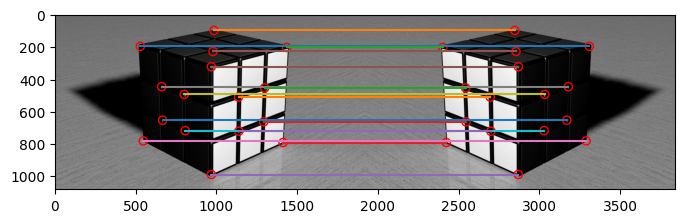

In [ ]:
show_matching_result(im1, im2, points1, points2)

# The Fundamental Matrix

In [ ]:
# compute the normalized fundamental matrix
F = compute_fundamental_matrix(points1, points2)

In [ ]:
# validate the fundamental matrix equation
p1 = points1.T[:, 0]
p2 = points2.T[:, 0]

np.round(p2.T @ F @ p1)

0.0

## The Normalized Fundamental Matrix

In [ ]:
# compute the normalized fundamental matrix
F = compute_fundamental_matrix_normalized(points1, points2)

In [ ]:
# validate the fundamental matrix equation
p1 = points1.T[:, 0]
p2 = points2.T[:, 0]

np.round(p2.T @ F @ p1)

-0.0

### Plot Epipolar lines

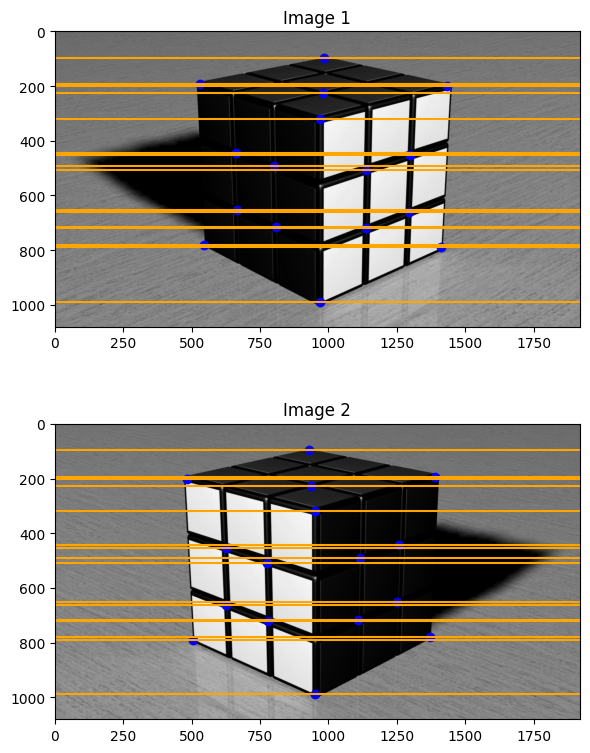

In [ ]:
plot_epipolar_lines(im1, im2, points1, points2, show_epipole=False)

### Plot Epipoles

In [ ]:
e1 = compute_epipole(F)
e2 = compute_epipole(F.T)

In [ ]:
# validate fundamental matrix equation for epipoles
np.round(e2.T @ F @ e1)

-0.0

In [ ]:
plot_epipolar_lines(im1, im2, points1, points2, show_epipole=True)